In [61]:
MODELS_FROM_FILE = 0
IMPORTANCES_FROM_FILE = 0

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif

from sklearn.pipeline import make_pipeline

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, recall_score, precision_score, balanced_accuracy_score, f1_score, roc_auc_score, fbeta_score, make_scorer, roc_curve, precision_recall_curve, accuracy_score
from sklearn.metrics import PrecisionRecallDisplay, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

    
pd.set_option("display.max_columns", None)
pd.set_option('max_colwidth', None)
pd.set_option('display.precision', 2)
pd.set_option('display.max_rows', 1000)


data_intermediate_dir = "data/intermediate/"
item_lvl_w_imp = pd.read_csv(data_intermediate_dir + "item_lvl_w_impairment.csv")

learning_disorder_cols = [
    "Diag: Specific Learning Disorder with Impairment in Reading",
    "Diag: Specific Learning Disorder with Impairment in Mathematics",
    "Diag: Intellectual Disability-Mild",
    "Diag: Borderline Intellectual Functioning",
    # no writing diagnosis because no writing tasks in HBN
]

diag_cols = {"Math": "New Diag: Specific Learning Disorder with Impairment in Mathematics",
            "Reading": "New Diag: Specific Learning Disorder with Impairment in Reading",
            "Intel Mild": "New Diag: Intellectual Disability-Mild",
            "Intel Bdl": "New Diag: Borderline Intellectual Functioning"}

In [62]:
# Create test-based or consensus diagnosis columns

item_lvl_w_imp[diag_cols["Math"]] = (item_lvl_w_imp["WIAT,WIAT_Num_Stnd"] < 85) | (item_lvl_w_imp["Diag: Specific Learning Disorder with Impairment in Mathematics"] == 1)
item_lvl_w_imp[diag_cols["Reading"]] = (item_lvl_w_imp["WIAT,WIAT_Word_Stnd"] < 85) | (item_lvl_w_imp["Diag: Specific Learning Disorder with Impairment in Reading"] == 1)
item_lvl_w_imp[diag_cols["Intel Mild"]] = (item_lvl_w_imp["WISC,WISC_FSIQ"] < 70) | (item_lvl_w_imp["Diag: Borderline Intellectual Functioning"] == 1)
item_lvl_w_imp[diag_cols["Intel Bdl"]] = ((item_lvl_w_imp["WISC,WISC_FSIQ"] < 85) & (item_lvl_w_imp["WISC,WISC_FSIQ"] > 70)) | (item_lvl_w_imp["Diag: Intellectual Disability-Mild"] == 1)

print(item_lvl_w_imp[diag_cols["Math"]].value_counts())
print(item_lvl_w_imp[diag_cols["Reading"]].value_counts())
print(item_lvl_w_imp[diag_cols["Intel Mild"]].value_counts())
print(item_lvl_w_imp[diag_cols["Intel Bdl"]].value_counts())

False    1046
True      374
Name: New Diag: Specific Learning Disorder with Impairment in Mathematics, dtype: int64
False    1042
True      378
Name: New Diag: Specific Learning Disorder with Impairment in Reading, dtype: int64
False    1369
True       51
Name: New Diag: Intellectual Disability-Mild, dtype: int64
False    1140
True      280
Name: New Diag: Borderline Intellectual Functioning, dtype: int64


In [63]:
def get_base_models_and_param_grids():
    
    # Define base models
    dt = DecisionTreeClassifier()
    rf = RandomForestClassifier()
    svc = svm.SVC()
    lr = LogisticRegression(solver="liblinear")
    
    # Impute missing values
    imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    
    # Standardize data
    scaler = StandardScaler()

    # Make pipelines
    dt_pipe = make_pipeline(imputer, scaler, dt)
    rf_pipe = make_pipeline(imputer, scaler, rf)
    svc_pipe = make_pipeline(imputer, scaler, svc)
    lr_pipe = make_pipeline(imputer, scaler, lr)
    
    # Define parameter grids to search for each pipe
    from scipy.stats import loguniform, uniform
    dt_param_grid = {
        "decisiontreeclassifier__min_samples_split": np.random.randint(2, 20, 30),
        "decisiontreeclassifier__max_depth": np.random.randint(1, 30, 30),
        "decisiontreeclassifier__min_samples_leaf": np.random.randint(1, 20, 30),
        "decisiontreeclassifier__max_leaf_nodes": np.random.randint(2, 50, 30),
        "decisiontreeclassifier__criterion": ['gini', 'entropy'],
        "decisiontreeclassifier__class_weight": ['balanced', None]
    }
    rf_param_grid = {
        'randomforestclassifier__max_depth' : np.random.randint(5, 150, 30),
        'randomforestclassifier__min_samples_split': np.random.randint(2, 50, 30),
        'randomforestclassifier__n_estimators': np.random.randint(50, 400, 10),
        'randomforestclassifier__min_samples_leaf': np.random.randint(1, 20, 30),
        'randomforestclassifier__max_features': ['auto', 'sqrt', 'log2', 0.25, 0.5, 0.75, 1.0],
        'randomforestclassifier__criterion': ['gini', 'entropy'],
        'randomforestclassifier__class_weight':["balanced", "balanced_subsample", None],
        "randomforestclassifier__class_weight": ['balanced', None]
    }
    svc_param_grid = {
        'svc__C': loguniform(1e-03, 1e+02),
        'svc__gamma': loguniform(1e-03, 1e+02),
        'svc__degree': uniform(2, 5),
        'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        "svc__class_weight": ['balanced', None]
    }
    lr_param_grid = {
        'logisticregression__C': loguniform(1e-5, 100),
        'logisticregression__penalty': ['l1', 'l2']
    }
    
    base_models_and_param_grids = [
        (dt_pipe, dt_param_grid),
        (rf_pipe, rf_param_grid),
        (svc_pipe, svc_param_grid),
        (lr_pipe, lr_param_grid),
    ]
    
    return base_models_and_param_grids

def get_best_classifier(base_model, grid, output_col, X_train, y_train):
    cv = StratifiedKFold(n_splits=10)
    rs = RandomizedSearchCV(estimator=base_model, param_distributions=grid, cv=cv, scoring="roc_auc", n_iter=100, n_jobs = -1)
    
    rs.fit(X_train, y_train) # On train_set, not train_train_set because do cross-validation
    
    best_estimator = rs.best_estimator_
    best_score = rs.best_score_
    
    # If chosen model is SVM add a predict_proba parameter (not needed for grid search, and slows it down significantly)
    if 'svc' in best_estimator.named_steps.keys():
        best_estimator.set_params(svc__probability=True)

    return (best_estimator, best_score)

In [64]:
def find_best_classifier_for_diag(diag, X_train, y_train):
    base_models_and_param_grids = get_base_models_and_param_grids()
    best_classifiers_and_scores = []
    
    for (base_model, grid) in base_models_and_param_grids:
        best_classifier_for_model, best_score_for_model = get_best_classifier(base_model, grid, diag, X_train, y_train)
        model_type = list(base_model.named_steps.keys())[-1]
        best_classifiers_and_scores.append([model_type, best_classifier_for_model, best_score_for_model])
    
    best_classifiers_and_scores = pd.DataFrame(best_classifiers_and_scores, columns = ["Model type", "Best classifier", "Best score"])
    display(best_classifiers_and_scores)
    best_classifier = best_classifiers_and_scores.sort_values("Best score", ascending=False)["Best classifier"].iloc[0]
    
    # If LogisticRegression is not much worse than the best model, prefer LogisticRegression (much faster than rest)
    best_base_model = best_classifiers_and_scores[best_classifiers_and_scores["Best classifier"] == best_classifier]["Model type"].iloc[0]
    if best_base_model != "logisticregression":
        best_score = best_classifiers_and_scores[best_classifiers_and_scores["Best classifier"] == best_classifier]["Best score"].iloc[0]
        lr_score = best_classifiers_and_scores[best_classifiers_and_scores["Model type"] == "logisticregression"]["Best score"].iloc[0]
        print("lr_score: ", lr_score, "; best_score: ", best_score)
        e = 0.03
        if best_score - lr_score <= e:
            best_classifier = best_classifiers_and_scores[best_classifiers_and_scores["Model type"] == "logisticregression"]["Best classifier"].iloc[0]
        
    print("best classifier:")
    print(best_classifier)
    
    return best_classifier

In [65]:
# Create datasets for each diagnosis (different input and output columns)

def get_input_and_output_cols_for_diag(diag):
    
    # For each diagnosis, remove corresponding consensus diagnosis from the input columns
    consensus_diag = "Diag:" + diag.split(":")[1]
    
    input_cols = [x for x in item_lvl_w_imp.columns if 
                        not x.startswith("WIAT")
                        and not x.startswith("WISC")
                        and not x in ["WHODAS_P,WHODAS_P_Total", "CIS_P,CIS_P_Score", "WHODAS_SR,WHODAS_SR_Score", "CIS_SR,CIS_SR_Total"]
                        and not x.startswith("New Diag: ")
                        and not x == consensus_diag]
    
    # Also remove "Diag: Intellectual Disability-Mild" when predicting "Diag: Borderline Intellectual Functioning"
    #   and vice versa
    if diag == diag_cols["Intel Mild"]:
        input_cols = [x for x in input_cols if x != "Diag: Borderline Intellectual Functioning"]
    if diag == diag_cols["Intel Bdl"]:
        input_cols = [x for x in input_cols if x != "Diag: Intellectual Disability-Mild"]
        
    output_col = diag
    
    return input_cols, output_col

datasets = {}
for key in diag_cols:
    
    diag = diag_cols[key]
    
    input_cols, output_col = get_input_and_output_cols_for_diag(diag)
    
    # Split train, validation, and test sets
    X_train, X_test, y_train, y_test = train_test_split(item_lvl_w_imp[input_cols], item_lvl_w_imp[output_col], test_size=0.3, random_state=1)
    X_train_train, X_val, y_train_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=1) 

    datasets[diag] = { "X_train": X_train,
                       "X_test": X_test,
                       "y_train": y_train,
                       "y_test": y_test,
                       "X_train_train": X_train_train,
                       "X_val": X_val,
                       "y_train_train": y_train_train,
                       "y_val": y_val}

In [66]:
# Calculate probability threshold
beta = 2
def calculate_threshold(classifier, X_train_train, y_train_train, X_val, y_val, b = beta):
    from numpy import nanargmax
    
    # Fit model on validation set
    classifier.fit(X_train_train, y_train_train)
    
    # Get predicted probabilities values
    y_val_pred_prob = classifier.predict_proba(X_val)
    
    # Calculate precision_recall_curve
    precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_pred_prob[:,1])
    
    # Calculate F-scores
    fscores = ((1+b**2) * precisions * recalls) / ((b**2 * precisions) + recalls)
    
    # Locate the index of the largest F-score
    ix = nanargmax(fscores)
    
    threshold = thresholds[ix]
    
    return threshold

In [67]:
# Find best classifier
if MODELS_FROM_FILE == 0:
    best_classifiers = {}
    for key in diag_cols:
        #if key == "Math": #DEBUG, REMOVE CONDITION
        diag = diag_cols[key]

        print(diag)

        X_train = datasets[diag]["X_train"]
        y_train = datasets[diag]["y_train"]
        if item_lvl_w_imp[diag].sum() > 70: # Don't use diagnoses if there are less than 50 positive examples
            best_classifier_for_diag = find_best_classifier_for_diag(diag, X_train, y_train)
            best_classifiers[diag] = best_classifier_for_diag
    print(best_classifiers)

New Diag: Specific Learning Disorder with Impairment in Mathematics


/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model type  \
0  decisiontreeclassifier   
1  randomforestclassifier   
2                     svc   
3      logisticregression   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

best classifier:
Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.05241543535820256, penalty='l1',
                                    solver='liblinear'))])
New Diag: Specific Learning Disorder with Impairment in Reading


/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model type  \
0  decisiontreeclassifier   
1  randomforestclassifier   
2                     svc   
3      logisticregression   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

best classifier:
Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.03585025482775998, penalty='l1',
                                    solver='liblinear'))])
New Diag: Intellectual Disability-Mild
New Diag: Borderline Intellectual Functioning


/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinea

Model type  \
0  decisiontreeclassifier   
1  randomforestclassifier   
2                     svc   
3      logisticregression   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

lr_score:  0.8611637246408202 ; best_score:  0.8813455707169157
best classifier:
Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.03813412810574982, penalty='l1',
                                    solver='liblinear'))])
{'New Diag: Specific Learning Disorder with Impairment in Mathematics': Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.05241543535820256, penalty='l1',
                                    solver='liblinear'))]), 'New Diag: Specific Learning Disorder with Impairment in Reading': Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegr

In [68]:
# Find best thresholds
def find_best_thresholds(beta=beta):
    best_thresholds = {}
    for diag in best_classifiers:
        print(diag)
        if item_lvl_w_imp[diag].sum() > 70: # Don't use diagnoses if there are less than 50 positive examples
            best_classifier_for_diag = best_classifiers[diag]
            X_train_train, y_train_train, X_val, y_val = datasets[diag]["X_train_train"], datasets[diag]["y_train_train"], datasets[diag]["X_val"], datasets[diag]["y_val"]
            threshold = calculate_threshold(best_classifier_for_diag, X_train_train, y_train_train, X_val, y_val, beta)
            best_thresholds[diag] = threshold
    print(best_thresholds)
    return best_thresholds

if MODELS_FROM_FILE == 0:
    best_thresholds = find_best_thresholds(beta=beta)

New Diag: Specific Learning Disorder with Impairment in Mathematics
New Diag: Specific Learning Disorder with Impairment in Reading


/var/folders/63/96f7chcx7qq5r9fq4x0x72bw0000gq/T/ipykernel_95542/1400528493.py:16: RuntimeWarning: invalid value encountered in true_divide
  fscores = ((1+b**2) * precisions * recalls) / ((b**2 * precisions) + recalls)


New Diag: Borderline Intellectual Functioning
{'New Diag: Specific Learning Disorder with Impairment in Mathematics': 0.19918223939961505, 'New Diag: Specific Learning Disorder with Impairment in Reading': 0.25162537869897234, 'New Diag: Borderline Intellectual Functioning': 0.2055978594237672}


/var/folders/63/96f7chcx7qq5r9fq4x0x72bw0000gq/T/ipykernel_95542/1400528493.py:16: RuntimeWarning: invalid value encountered in true_divide
  fscores = ((1+b**2) * precisions * recalls) / ((b**2 * precisions) + recalls)


In [69]:
from joblib import dump, load
if MODELS_FROM_FILE == 0:
    # Save best classifiers and thresholds 
    dump(best_classifiers, 'best-classifiers-cons-and-thresh-item-lvl.joblib', compress=1)
    dump(best_thresholds, 'best-thresholds-cons-and-thresh-item-lvl.joblib', compress=1)

In [70]:
if MODELS_FROM_FILE == 1:
    best_classifiers = load('best-classifiers-cons-and-thresh-item-lvl.joblib')
    best_thresholds = load('best-thresholds-cons-and-thresh-item-lvl.joblib')

In [71]:
import math
metric_names = ['TP','TN','FP','FN','Prevalence','Accuracy','Precision','NPV','FDR','FOR','check_Pos','check_Neg','Recall (Sensitivity)','FPR','FNR','TNR (Specificity)','check_Pos2','check_Neg2','LR+','LR-','DOR','F1','FBeta','MCC','BM','MK','Predicted Positive Ratio']   
def get_matrix_metrics(real_values,pred_values,beta):
    CM = confusion_matrix(real_values,pred_values)
    TN = CM[0][0]+0.01 # +0.01 To avoid division by 0 errors
    FN = CM[1][0]+0.01
    TP = CM[1][1]+0.01
    FP = CM[0][1]+0.01
    Population = TN+FN+TP+FP
    Prevalence = round( (TP+FN) / Population,2)
    Accuracy   = round( (TP+TN) / Population,4)
    Precision  = round( TP / (TP+FP),4 )
    NPV        = round( TN / (TN+FN),4 )
    FDR        = round( FP / (TP+FP),4 )
    FOR        = round( FN / (TN+FN),4 ) 
    check_Pos  = Precision + FDR
    check_Neg  = NPV + FOR
    Recall     = round( TP / (TP+FN),4 )
    FPR        = round( FP / (TN+FP),4 )
    FNR        = round( FN / (TP+FN),4 )
    TNR        = round( TN / (TN+FP),4 ) 
    check_Pos2 = Recall + FNR
    check_Neg2 = FPR + TNR
    LRPos      = round( Recall/FPR,4 ) 
    LRNeg      = round( FNR / TNR ,4 )
    DOR        = round( LRPos/LRNeg)
    #DOR        = 1 # FIX, LINE ABOVE
    F1         = round ( 2 * ((Precision*Recall)/(Precision+Recall)),4)
    FBeta      = round ( (1+beta**2)*((Precision*Recall)/((beta**2 * Precision)+ Recall)) ,4)
    MCC        = round ( ((TP*TN)-(FP*FN))/math.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))  ,4)
    BM         = Recall+TNR-1
    MK         = Precision+NPV-1   
    Predicted_Positive_Ratio = round( (TP+FP) / Population,2)
    
    mat_met = [TP,TN,FP,FN,Prevalence,Accuracy,Precision,NPV,FDR,FOR,check_Pos,check_Neg,Recall,FPR,FNR,TNR,check_Pos2,check_Neg2,LRPos,LRNeg,DOR,F1,FBeta,MCC,BM,MK,Predicted_Positive_Ratio]
    return (mat_met)

In [72]:
def get_metrics(classifier, threshold, X, y, print_output_flag = 0):
       
    y_pred_prob = classifier.predict_proba(X)
    y_pred = (y_pred_prob[:,1] >= threshold).astype(bool) 
    
    roc_auc = roc_auc_score(y, y_pred_prob[:,1])
    
    metrics = get_matrix_metrics(y, y_pred, beta=3)
    metrics.append(roc_auc)
    
    if print_output_flag:
        
        # Display confusion matrix
        cm = confusion_matrix(y, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.show()

        # Display the ROC curve 
        fpr, tpr, thresholds = roc_curve(y, y_pred_prob[:,1])
        plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
        plt.plot(fpr, tpr, marker='.', label='Model')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.show()
        
        display = PrecisionRecallDisplay.from_predictions(y, y_pred_prob[:,1])
        display.ax_.set_title("Precision-Recall curve")
        plt.scatter(metrics[metric_names.index("Recall (Sensitivity)")], metrics[metric_names.index("Precision")], marker='o', color='black', label='Best')
        plt.show()
        
    return metrics

New Diag: Specific Learning Disorder with Impairment in Mathematics


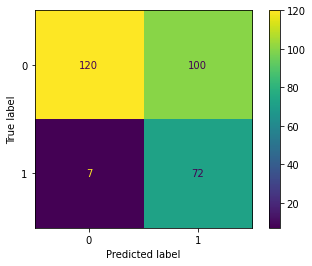

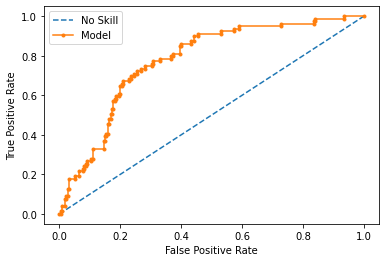

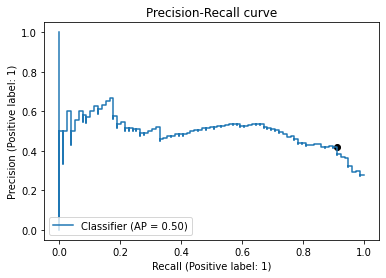

New Diag: Specific Learning Disorder with Impairment in Reading


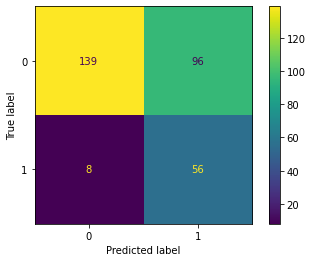

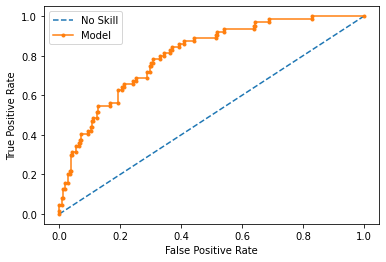

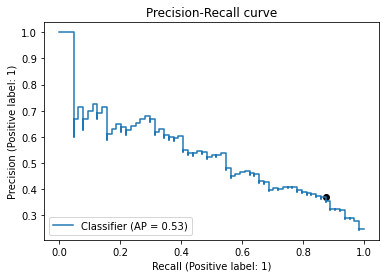

New Diag: Borderline Intellectual Functioning


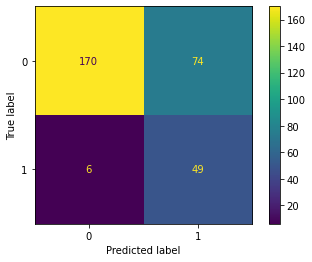

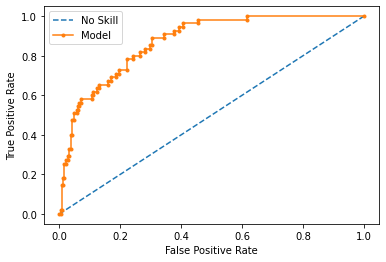

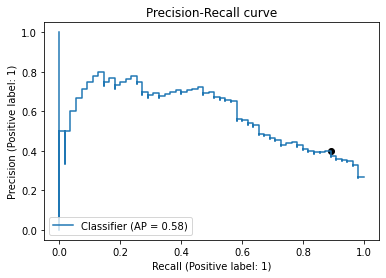

,Diag,TP,TN,FP,FN,Prevalence,Accuracy,Precision,NPV,FDR,FOR,check_Pos,check_Neg,Recall (Sensitivity),FPR,FNR,TNR (Specificity),check_Pos2,check_Neg2,LR+,LR-,DOR,F1,FBeta,MCC,BM,MK,Predicted Positive Ratio,ROC AUC
2,New Diag: Borderline Intellectual Functioning,49.01,170.01,74.01,6.01,0.18,0.73,0.40,0.97,0.60,0.03,1.0,1.0,0.89,0.30,0.11,0.70,1.0,1.0,2.94,0.16,19,0.55,0.79,0.46,0.59,0.36,0.41,0.87
1,New Diag: Specific Learning Disorder with Impairment in Reading,56.01,139.01,96.01,8.01,0.21,0.65,0.37,0.95,0.63,0.05,1.0,1.0,0.87,0.41,0.13,0.59,1.0,1.0,2.14,0.21,10,0.52,0.77,0.38,0.47,0.31,0.51,0.80
0,New Diag: Specific Learning Disorder with Impairment in Mathematics,72.01,120.01,100.01,7.01,0.26,0.64,0.42,0.94,0.58,0.06,1.0,1.0,0.91,0.45,0.09,0.55,1.0,1.0,2.01,0.16,12,0.57,0.82,0.41,0.46,0.36,0.58,0.78


In [73]:
# Check performance of the final model on validation set for all models

results_val_set = []
for diag in best_classifiers:
    print(diag)
    classifier = best_classifiers[diag]
    threshold = best_thresholds[diag]
    X_val, y_val = datasets[diag]["X_val"], datasets[diag]["y_val"]
    metrics = get_metrics(classifier, threshold, X_val, y_val, 1)
    prevalence = item_lvl_w_imp[diag].sum()/len(item_lvl_w_imp)
    results_val_set.append([
        diag, 
        *metrics])
restults_val_set_df = pd.DataFrame(results_val_set, columns=["Diag"]+metric_names+["ROC AUC"])
restults_val_set_df.sort_values(by="ROC AUC", ascending=False)

In [74]:
# Do cross-validation to get more reliable ROC AUC scores (f1 harder to obtain with cross validation - need to change threshold)

auc_cv_mean_val_set = []
auc_cv_std_val_set = []
for diag in best_classifiers:
    
    print(diag)
    
    classifier = best_classifiers[diag]

    cv = StratifiedKFold(n_splits=5)
    X_train, y_train = datasets[diag]["X_train"], datasets[diag]["y_train"]
    auc = cross_val_score(classifier, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)

    auc_cv_mean_val_set.append(auc.mean())
    auc_cv_std_val_set.append(auc.std())
restults_val_set_df["ROC AUC Mean CV"] = pd.Series(auc_cv_mean_val_set)
restults_val_set_df["ROC AUC Std CV"] = pd.Series(auc_cv_std_val_set)
restults_val_set_df

New Diag: Specific Learning Disorder with Impairment in Mathematics
New Diag: Specific Learning Disorder with Impairment in Reading
New Diag: Borderline Intellectual Functioning


,Diag,TP,TN,FP,FN,Prevalence,Accuracy,Precision,NPV,FDR,FOR,check_Pos,check_Neg,Recall (Sensitivity),FPR,FNR,TNR (Specificity),check_Pos2,check_Neg2,LR+,LR-,DOR,F1,FBeta,MCC,BM,MK,Predicted Positive Ratio,ROC AUC,ROC AUC Mean CV,ROC AUC Std CV
0,New Diag: Specific Learning Disorder with Impairment in Mathematics,72.01,120.01,100.01,7.01,0.26,0.64,0.42,0.94,0.58,0.06,1.0,1.0,0.91,0.45,0.09,0.55,1.0,1.0,2.01,0.16,12,0.57,0.82,0.41,0.46,0.36,0.58,0.78,0.77,0.03
1,New Diag: Specific Learning Disorder with Impairment in Reading,56.01,139.01,96.01,8.01,0.21,0.65,0.37,0.95,0.63,0.05,1.0,1.0,0.87,0.41,0.13,0.59,1.0,1.0,2.14,0.21,10,0.52,0.77,0.38,0.47,0.31,0.51,0.80,0.84,0.03
2,New Diag: Borderline Intellectual Functioning,49.01,170.01,74.01,6.01,0.18,0.73,0.40,0.97,0.60,0.03,1.0,1.0,0.89,0.30,0.11,0.70,1.0,1.0,2.94,0.16,19,0.55,0.79,0.46,0.59,0.36,0.41,0.87,0.86,0.03


In [59]:
for diag in best_classifiers:
    print(diag)
    print(list(best_classifiers[diag].named_steps.keys())[-1])
    if list(best_classifiers[diag].named_steps.keys())[-1] == "randomforestclassifier":
        importances = best_classifiers[diag].named_steps[list(best_classifiers[diag].named_steps.keys())[-1]].feature_importances_
        X_train = datasets[diag]["X_train"]
        importances = pd.DataFrame(zip(X_train.columns, importances), columns=["Feature", "Importance"])
        pd.set_option('display.precision', 2)
        display(importances.sort_values(by="Importance", ascending=False).iloc[0:10])
        #display(importances[importances["Feature"].str.startswith("NIH")].sort_values(by="Importance", ascending=False).iloc[0:1000])
    else:
        importances = best_classifiers[diag].named_steps[list(best_classifiers[diag].named_steps.keys())[-1]].coef_
        X_train = datasets[diag]["X_train"]
        importances = pd.DataFrame(zip(X_train.columns, abs(importances[0])), columns=["Feature", "Importance"])
        pd.set_option('display.precision', 2)
        display(importances.sort_values(by="Importance", ascending=False).iloc[0:10])
        #display(importances[importances["Feature"].str.startswith("NIH")].sort_values(by="Importance", ascending=False).iloc[0:1000])

New Diag: Specific Learning Disorder with Impairment in Mathematics
logisticregression


,Feature,Importance
919,"C3SR,C3SR_38",0.29
942,Diag: Specific Learning Disorder with Impairment in Written Expression,0.28
974,Diag: Language Disorder,0.26
5,"NIH_Scores,NIH7_List",0.25
4,"NIH_Scores,NIH7_Flanker",0.20
966,Diag: Intellectual Disability-Mild,0.19
937,Diag: Agoraphobia,0.17
0,"Basic_Demos,Age",0.14
1009,Diag: Specific Learning Disorder with Impairment in Reading,0.14
817,"WHODAS_SR,WHODAS_SR_11",0.10


New Diag: Specific Learning Disorder with Impairment in Reading
logisticregression


,Feature,Importance
914,"C3SR,C3SR_33",0.84
919,"C3SR,C3SR_38",0.44
741,"PSI,PSI_18",0.33
942,Diag: Specific Learning Disorder with Impairment in Written Expression,0.28
473,"APQ_P,APQ_P_08",0.24
137,"SCQ,SCQ_05",0.23
917,"C3SR,C3SR_36",0.22
5,"NIH_Scores,NIH7_List",0.19
651,"APQ_SR,APQ_SR_05",0.17
894,"C3SR,C3SR_13",0.16


New Diag: Borderline Intellectual Functioning
logisticregression


,Feature,Importance
5,"NIH_Scores,NIH7_List",0.47
741,"PSI,PSI_18",0.37
973,Diag: Language Disorder,0.32
2,"NIH_Scores,NIH7_Card",0.22
955,Diag: Specific Learning Disorder with Impairment in Mathematics,0.13
35,"SympChck,CSC_15C",0.12
421,"CBCL,CBCL_79",0.11
103,"SympChck,CSC_49C",0.08
890,"C3SR,C3SR_09",0.08
171,"SCQ,SCQ_39",0.07


New Diag: Specific Learning Disorder with Impairment in Mathematics


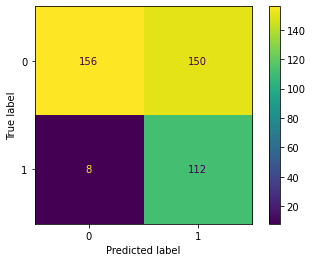

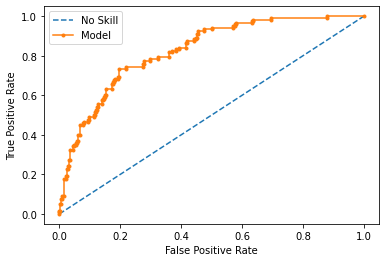

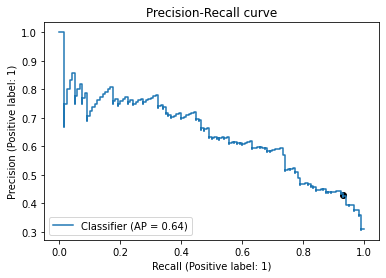

New Diag: Specific Learning Disorder with Impairment in Reading


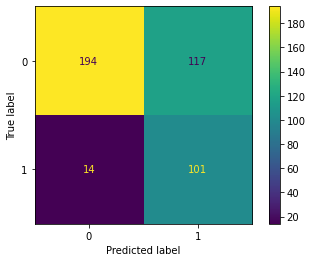

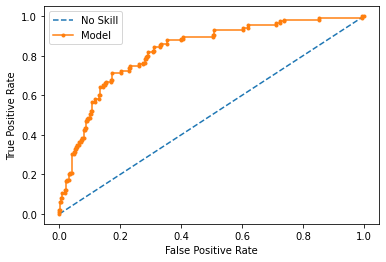

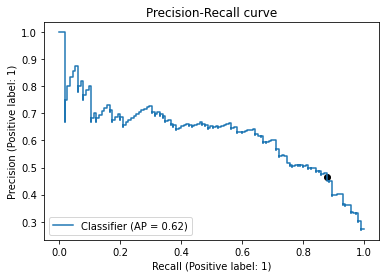

New Diag: Borderline Intellectual Functioning


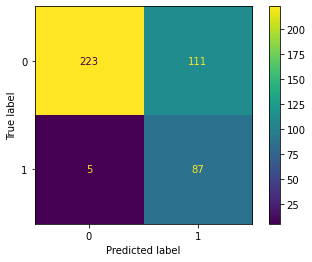

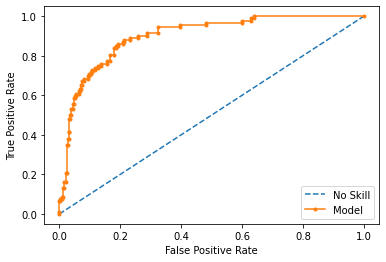

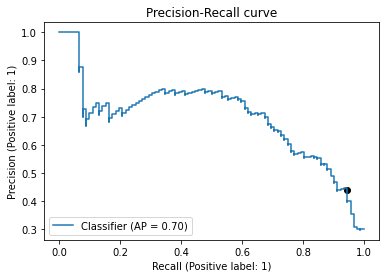

,Diag,Recall (Sensitivity),TNR (Specificity),Predicted Positive Ratio,ROC AUC
2,New Diag: Borderline Intellectual Functioning,0.95,0.67,0.46,0.90
1,New Diag: Specific Learning Disorder with Impairment in Reading,0.88,0.62,0.51,0.83
0,New Diag: Specific Learning Disorder with Impairment in Mathematics,0.93,0.51,0.62,0.83


In [60]:
# Check performance of the final model on test set for all models

results_test_set = []
for diag in best_classifiers:
    print(diag)
    classifier = best_classifiers[diag]
    threshold = best_thresholds[diag]
    X_test, y_test = datasets[diag]["X_test"], datasets[diag]["y_test"]
    metrics = get_metrics(classifier, threshold, X_test, y_test, 1)
    prevalence = item_lvl_w_imp[diag].sum()/len(item_lvl_w_imp)
    results_test_set.append([
        diag, 
        *metrics])
restults_test_set_df = pd.DataFrame(results_test_set, columns=["Diag"]+metric_names+["ROC AUC"])
restults_test_set_df[["Diag", "Recall (Sensitivity)", "TNR (Specificity)", "Predicted Positive Ratio", "ROC AUC"]].sort_values(by="TNR (Specificity)", ascending=False)

### Feature importance

In [75]:
if IMPORTANCES_FROM_FILE == 1:
    forward_feature_objects = {}
    try:
        forward_feature_objects = load('forward-sfs-cons-and-thresh-item-lvl.joblib')
    except Exception as e: print(e)

In [76]:
# Find elbow of the curve (draw a line from the first to the last point of the curve and then find the data point that is farthest away from that line) https://stackoverflow.com/questions/2018178/finding-the-best-trade-off-point-on-a-curve 
def find_elbow(curve):
    from numpy import matlib 
    n_points = len(curve)
    all_coord = np.vstack((range(n_points), curve)).T
    first_point = all_coord[0]
    line_vec = all_coord[-1] - all_coord[0]
    line_vec_norm = line_vec / np.sqrt(np.sum(line_vec**2))
    vec_from_first = all_coord - first_point
    scalar_product = np.sum(vec_from_first * np.matlib.repmat(line_vec_norm, n_points, 1), axis=1)
    vec_from_first_parallel = np.outer(scalar_product, line_vec_norm)
    vec_to_line = vec_from_first - vec_from_first_parallel
    dist_to_line = np.sqrt(np.sum(vec_to_line ** 2, axis=1))
    idx_of_best_point = np.argmax(dist_to_line)
    return idx_of_best_point + 1

def analyze_importances(importances):
    importances_list = []
    for key in importances:
        importances_list.append(importances[key]['avg_score'])
    importances_df = pd.DataFrame(importances_list, index=importances.keys(), columns=["ROC AUC"])

    max_score = max(importances_list)
    n_cols_max_score = importances_df[importances_df["ROC AUC"] == max_score].index[0]
    print("Max score: ", max_score, " at ", n_cols_max_score, " features")
    features_up_to_max_score = importances[n_cols_max_score]["feature_names"]

    plt.figure(figsize=(16,8))
    plt.plot(importances_df)
    plt.xticks(np.arange(1,100, 3))
    plt.vlines(np.arange(1,100, 3), ymin=min(importances_list), ymax=max(importances_list), colors='purple', ls=':', lw=1)
    plt.show()
    
    optimal_nb_features = find_elbow(importances_list)
    print("Optimal number of features: ", optimal_nb_features)
    
    features_up_to_optimal = importances[optimal_nb_features]["feature_names"]
    display(features_up_to_optimal)
    
    return (features_up_to_optimal, features_up_to_max_score)

New Diag: Specific Learning Disorder with Impairment in Mathematics


/Users/home/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Max score:  0.8029973583851104  at  54  features


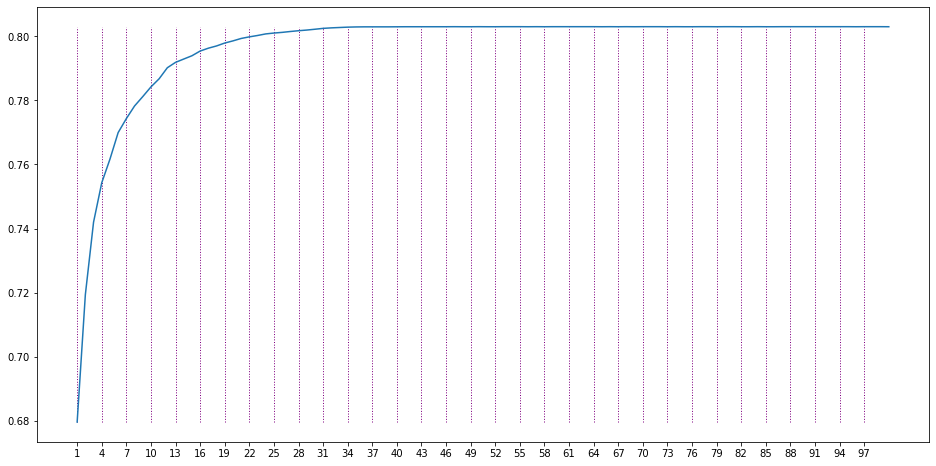

Optimal number of features:  13


('NIH_Scores,NIH7_Flanker',
 'NIH_Scores,NIH7_List',
 'SympChck,CSC_21C',
 'ASSQ,ASSQ_10',
 'CBCL,CBCL_32',
 'CBCL,CBCL_61',
 'APQ_SR,APQ_SR_06',
 'PhenX_Neighborhood,PhenX_NS_02',
 'SCARED_SR,SCARED_SR_SC',
 'C3SR,C3SR_38',
 'Diag: Agoraphobia',
 'Diag: Intellectual Disability-Mild',
 'Diag: Specific Learning Disorder with Impairment in Reading')

New Diag: Specific Learning Disorder with Impairment in Reading
Max score:  0.8357665956369451  at  37  features


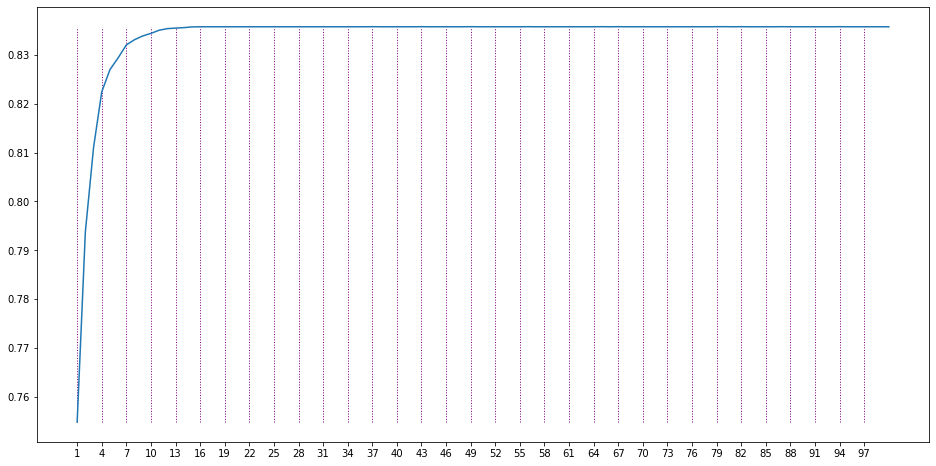

Optimal number of features:  8


('NIH_Scores,NIH7_List',
 'PSI,PSI_18',
 'PSI,PSI_35',
 'SCARED_SR,SCARED_SR_GD',
 'C3SR,C3SR_33',
 'C3SR,C3SR_38',
 'Diag: Specific Learning Disorder with Impairment in Written Expression',
 'Diag: Intellectual Disability-Mild')

New Diag: Borderline Intellectual Functioning
Max score:  0.869277171551774  at  16  features


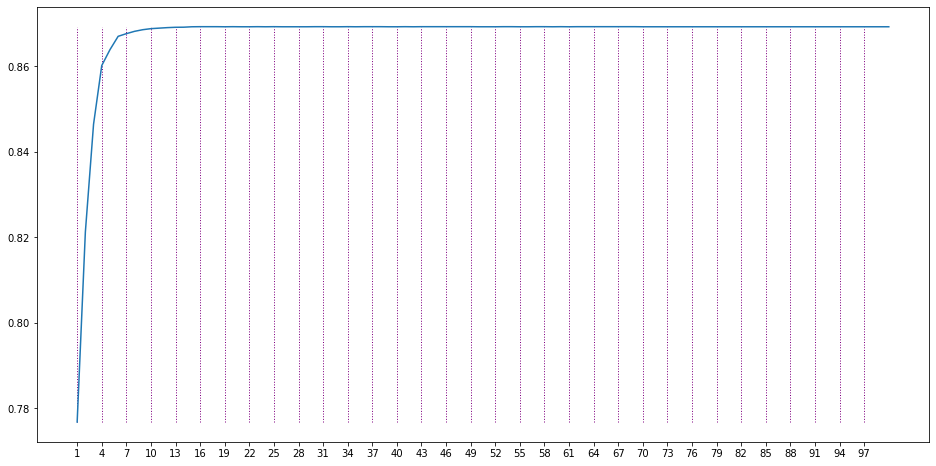

Optimal number of features:  6


('NIH_Scores,NIH7_Card',
 'NIH_Scores,NIH7_List',
 'CBCL,CBCL_79',
 'PSI,PSI_18',
 'Diag: Specific Learning Disorder with Impairment in Mathematics',
 'Diag: Language Disorder')

In [77]:
from mlxtend.feature_selection import SequentialFeatureSelector

if IMPORTANCES_FROM_FILE == 0:
    forward_feature_subsets = {}
    forward_feature_objects = {}
    for diag in best_classifiers:
        print(diag)
        diag_classifier = best_classifiers[diag]

        cv = StratifiedKFold(n_splits=3)
        sfs = SequentialFeatureSelector(diag_classifier, 
              k_features=100,
              forward=True, 
              scoring='roc_auc',
              cv=cv,
              n_jobs=-1)

        X_train, y_train = datasets[diag]["X_train"], datasets[diag]["y_train"]
        sfs = sfs.fit(X_train, y_train)

        forward_feature_subsets[diag] = sfs.subsets_
        forward_feature_objects[diag] = sfs
        
        analyze_importances(forward_feature_objects[diag].subsets_)

In [78]:
# Save importances to file
if IMPORTANCES_FROM_FILE == 0:
    dump(forward_feature_objects, 'forward-sfs-cons-and-thresh-item-lvl.joblib', compress=1)

New Diag: Specific Learning Disorder with Impairment in Mathematics
Max score:  0.8029973583851104  at  54  features


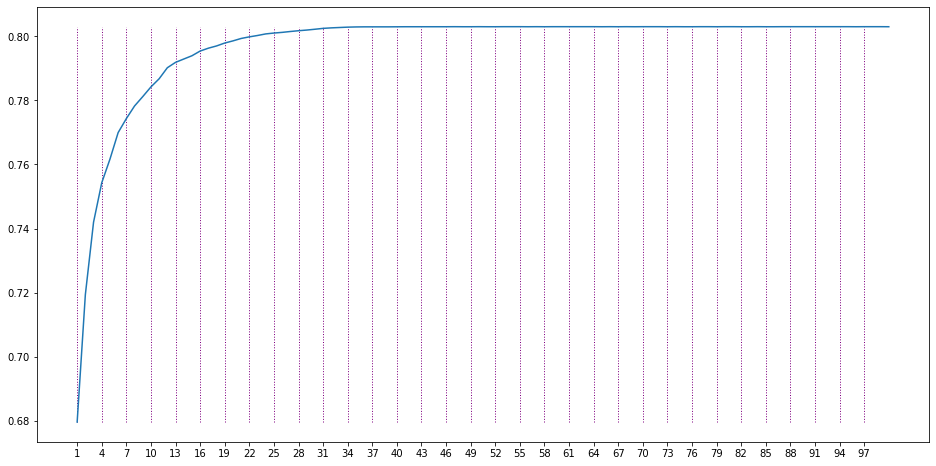

Optimal number of features:  13


('NIH_Scores,NIH7_Flanker',
 'NIH_Scores,NIH7_List',
 'SympChck,CSC_21C',
 'ASSQ,ASSQ_10',
 'CBCL,CBCL_32',
 'CBCL,CBCL_61',
 'APQ_SR,APQ_SR_06',
 'PhenX_Neighborhood,PhenX_NS_02',
 'SCARED_SR,SCARED_SR_SC',
 'C3SR,C3SR_38',
 'Diag: Agoraphobia',
 'Diag: Intellectual Disability-Mild',
 'Diag: Specific Learning Disorder with Impairment in Reading')

Score using all features: 


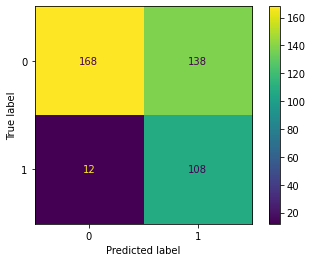

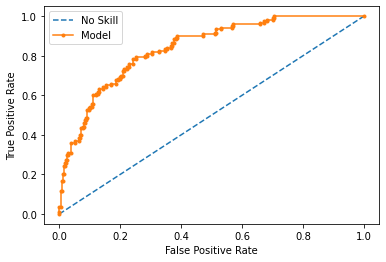

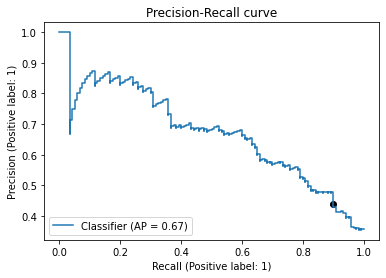

ROC AUC:  0.8392701525054467
Recall (Sensitivity):  0.8999
TNR (Specificity):  0.549
Predicted Positive Ratio:  0.58
Precision:  0.439
FPR:  0.451
Performance on test set using optimal number of columns: 


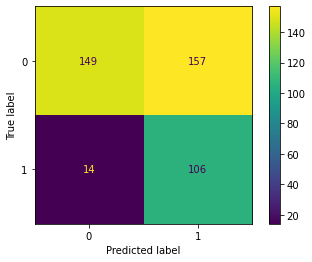

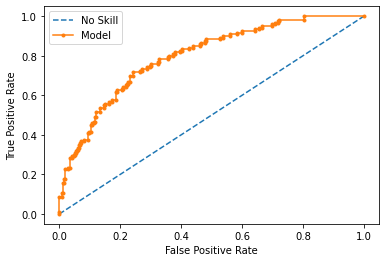

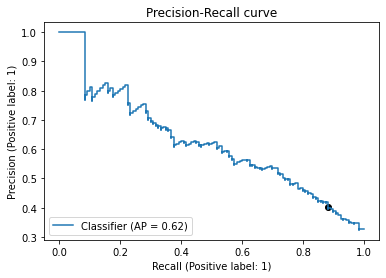

ROC AUC:  0.7973583877995642
Recall (Sensitivity):  0.8833
TNR (Specificity):  0.4869
Predicted Positive Ratio:  0.62
Precision:  0.403
FPR:  0.5131
Performance on test set using number of columns with maximum score


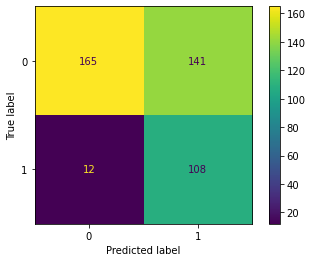

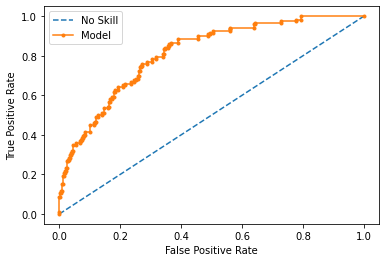

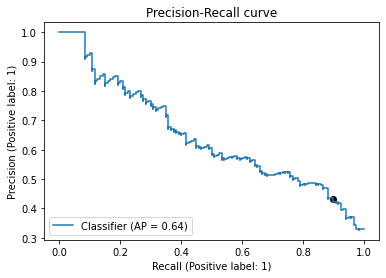

ROC AUC:  0.8126361655773421
Recall (Sensitivity):  0.8999
TNR (Specificity):  0.5392
Predicted Positive Ratio:  0.58
Precision:  0.4337
FPR:  0.4608


[[1012, 0.8392701525054467, 0.8999, 0.549, 0.58, 0.439, 0.451],
 [13, 0.7973583877995642, 0.8833, 0.4869, 0.62, 0.403, 0.5131],
 [54, 0.8126361655773421, 0.8999, 0.5392, 0.58, 0.4337, 0.4608]]

New Diag: Specific Learning Disorder with Impairment in Reading
Max score:  0.8357665956369451  at  37  features


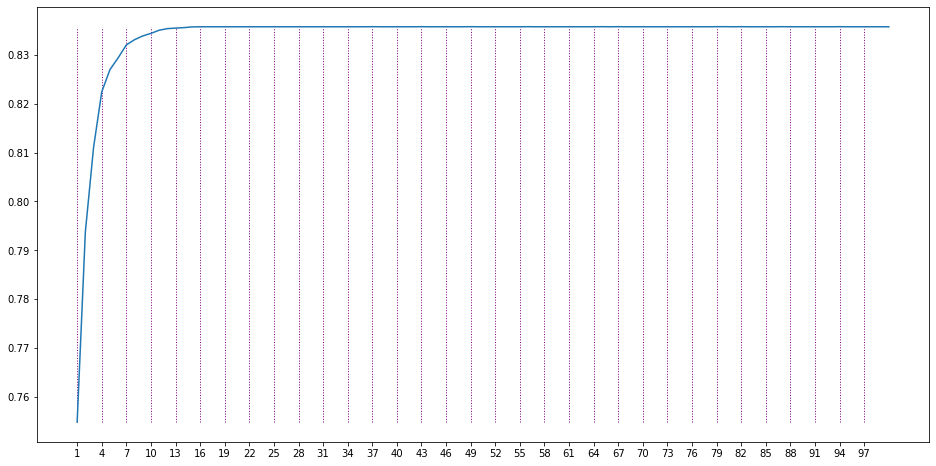

Optimal number of features:  8


('NIH_Scores,NIH7_List',
 'PSI,PSI_18',
 'PSI,PSI_35',
 'SCARED_SR,SCARED_SR_GD',
 'C3SR,C3SR_33',
 'C3SR,C3SR_38',
 'Diag: Specific Learning Disorder with Impairment in Written Expression',
 'Diag: Intellectual Disability-Mild')

Score using all features: 


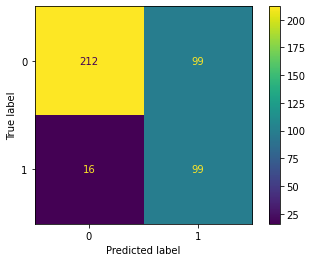

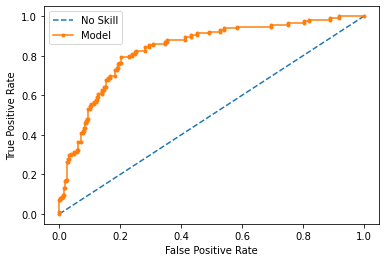

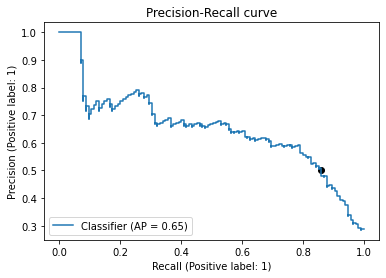

ROC AUC:  0.8363763455892632
Recall (Sensitivity):  0.8608
TNR (Specificity):  0.6817
Predicted Positive Ratio:  0.46
Precision:  0.5
FPR:  0.3183
Performance on test set using optimal number of columns: 


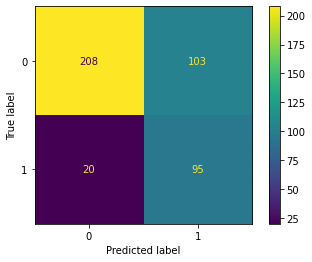

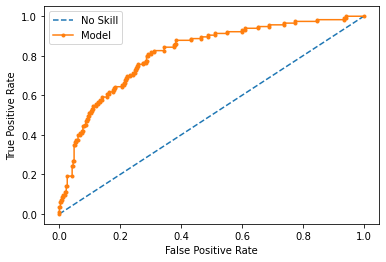

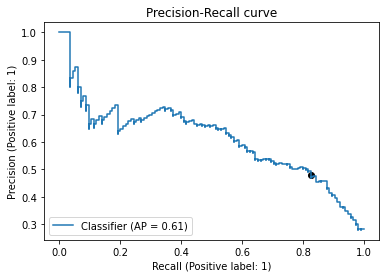

ROC AUC:  0.8134069621137985
Recall (Sensitivity):  0.826
TNR (Specificity):  0.6688
Predicted Positive Ratio:  0.46
Precision:  0.4798
FPR:  0.3312
Performance on test set using number of columns with maximum score


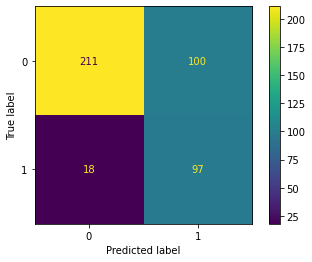

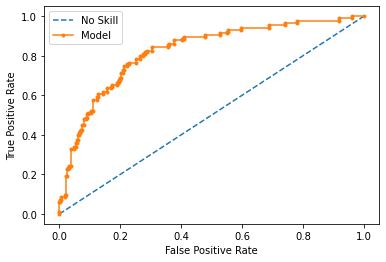

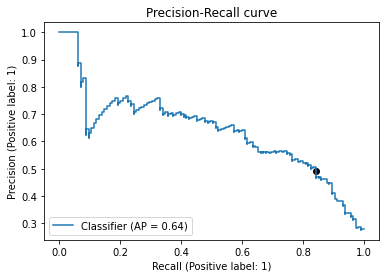

ROC AUC:  0.8241856563679575
Recall (Sensitivity):  0.8434
TNR (Specificity):  0.6784
Predicted Positive Ratio:  0.46
Precision:  0.4924
FPR:  0.3216


[[1012, 0.8363763455892632, 0.8608, 0.6817, 0.46, 0.5, 0.3183],
 [8, 0.8134069621137985, 0.826, 0.6688, 0.46, 0.4798, 0.3312],
 [37, 0.8241856563679575, 0.8434, 0.6784, 0.46, 0.4924, 0.3216]]

New Diag: Borderline Intellectual Functioning
Max score:  0.869277171551774  at  16  features


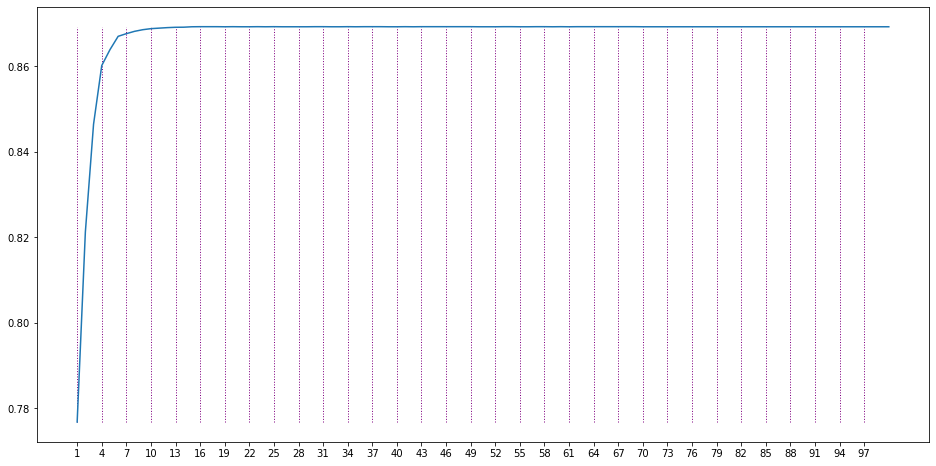

Optimal number of features:  6


('NIH_Scores,NIH7_Card',
 'NIH_Scores,NIH7_List',
 'CBCL,CBCL_79',
 'PSI,PSI_18',
 'Diag: Specific Learning Disorder with Impairment in Mathematics',
 'Diag: Language Disorder')

Score using all features: 


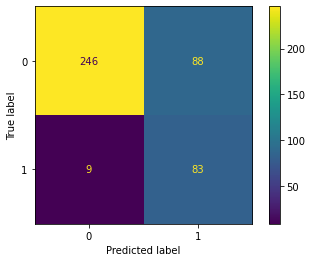

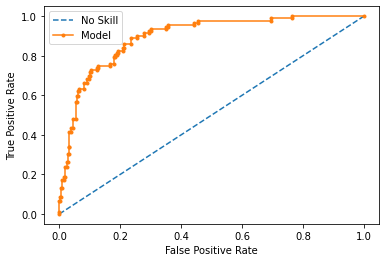

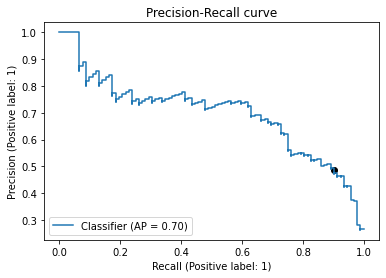

ROC AUC:  0.8960231710492059
Recall (Sensitivity):  0.9021
TNR (Specificity):  0.7365
Predicted Positive Ratio:  0.4
Precision:  0.4854
FPR:  0.2635
Performance on test set using optimal number of columns: 


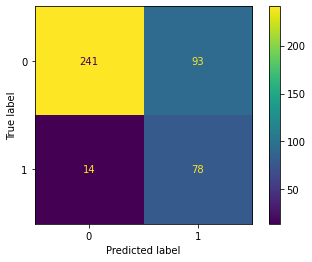

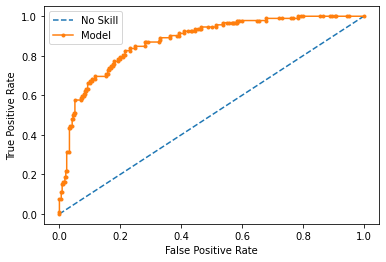

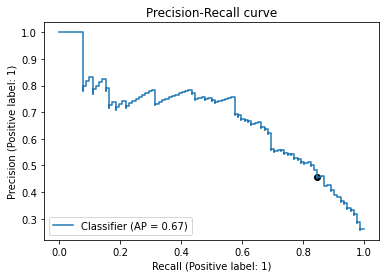

ROC AUC:  0.8759600364488414
Recall (Sensitivity):  0.8478
TNR (Specificity):  0.7215
Predicted Positive Ratio:  0.4
Precision:  0.4561
FPR:  0.2785
Performance on test set using number of columns with maximum score


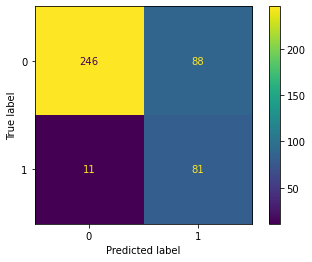

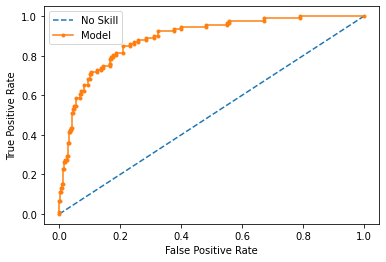

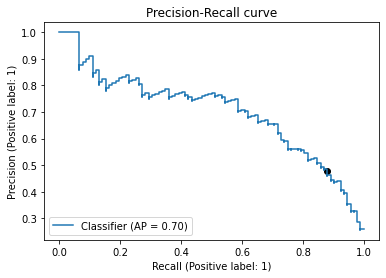

ROC AUC:  0.8891890132777922
Recall (Sensitivity):  0.8804
TNR (Specificity):  0.7365
Predicted Positive Ratio:  0.4
Precision:  0.4793
FPR:  0.2635


[[1011, 0.8960231710492059, 0.9021, 0.7365, 0.4, 0.4854, 0.2635],
 [6, 0.8759600364488414, 0.8478, 0.7215, 0.4, 0.4561, 0.2785],
 [16, 0.8891890132777922, 0.8804, 0.7365, 0.4, 0.4793, 0.2635]]

In [79]:
# Print sfs results

sfs_results_test_set = {}

for diag in forward_feature_objects:
    print(diag)
    
    sfs_results_test_set_diag = []
    
    features_up_to_optimal, features_up_to_max_score = analyze_importances(forward_feature_objects[diag].subsets_)
    features_up_to_optimal = list(features_up_to_optimal)
    features_up_to_max_score = list(features_up_to_max_score)
    
    # Test both subsets on test set
    classifier = best_classifiers[diag]
    threshold = best_thresholds[diag]
    
    X_train, y_train = datasets[diag]["X_train"], datasets[diag]["y_train"]
    X_test, y_test = datasets[diag]["X_test"], datasets[diag]["y_test"]
    
    # All features
    # Create new pipeline with the same params (need to re-train the imputer on less features)
    new_classifier = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='median'), StandardScaler(), classifier[2])
    new_classifier.fit(X_train, y_train)
    print("Score using all features: ")
    metrics = get_metrics(new_classifier, threshold, X_test, y_test, 1)
    print("ROC AUC: ", metrics[-1])
    print("Recall (Sensitivity): ", metrics[metric_names.index("Recall (Sensitivity)")])
    print("TNR (Specificity): ", metrics[metric_names.index("TNR (Specificity)")])
    print("Predicted Positive Ratio: ", metrics[metric_names.index("Predicted Positive Ratio")])
    print("Precision: ", metrics[metric_names.index("Precision")])
    print("FPR: ", metrics[metric_names.index("FPR")])
    sfs_results_test_set_diag.append([
                                    len(X_test.columns),
                                    metrics[-1], 
                                    metrics[metric_names.index("Recall (Sensitivity)")],
                                    metrics[metric_names.index("TNR (Specificity)")],
                                    metrics[metric_names.index("Predicted Positive Ratio")],
                                    metrics[metric_names.index("Precision")],
                                    metrics[metric_names.index("FPR")]])
    
    # Optimal number of features
    # Create new pipeline with the same params (need to re-train the imputer on less features)
    new_classifier = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='median'), StandardScaler(), classifier[2])
    new_classifier.fit(X_train[features_up_to_optimal], y_train)
    print("Performance on test set using optimal number of columns: ")
    metrics = get_metrics(new_classifier, threshold, X_test[features_up_to_optimal], y_test, 1)
    print("ROC AUC: ", metrics[-1])
    print("Recall (Sensitivity): ", metrics[metric_names.index("Recall (Sensitivity)")])
    print("TNR (Specificity): ", metrics[metric_names.index("TNR (Specificity)")])
    print("Predicted Positive Ratio: ", metrics[metric_names.index("Predicted Positive Ratio")])
    print("Precision: ", metrics[metric_names.index("Precision")])
    print("FPR: ", metrics[metric_names.index("FPR")])
    sfs_results_test_set_diag.append([
                                    len(features_up_to_optimal),
                                    metrics[-1], 
                                    metrics[metric_names.index("Recall (Sensitivity)")],
                                    metrics[metric_names.index("TNR (Specificity)")],
                                    metrics[metric_names.index("Predicted Positive Ratio")],
                                    metrics[metric_names.index("Precision")],
                                    metrics[metric_names.index("FPR")]])

    # Number of features with maximum score
    # Create new pipeline with the same params (need to re-train the imputer on less features)
    new_classifier = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='median'), StandardScaler(), classifier[2])
    new_classifier.fit(X_train[features_up_to_max_score], y_train)
    print("Performance on test set using number of columns with maximum score")
    metrics = get_metrics(new_classifier, threshold, X_test[features_up_to_max_score], y_test, 1)
    print("ROC AUC: ", metrics[-1])
    print("Recall (Sensitivity): ", metrics[metric_names.index("Recall (Sensitivity)")])
    print("TNR (Specificity): ", metrics[metric_names.index("TNR (Specificity)")])
    print("Predicted Positive Ratio: ", metrics[metric_names.index("Predicted Positive Ratio")])
    print("Precision: ", metrics[metric_names.index("Precision")])
    print("FPR: ", metrics[metric_names.index("FPR")])
    sfs_results_test_set_diag.append([
                                    len(features_up_to_max_score),
                                    metrics[-1], 
                                    metrics[metric_names.index("Recall (Sensitivity)")],
                                    metrics[metric_names.index("TNR (Specificity)")],
                                    metrics[metric_names.index("Predicted Positive Ratio")],
                                    metrics[metric_names.index("Precision")],
                                    metrics[metric_names.index("FPR")]])
    
    display(sfs_results_test_set_diag)
    sfs_results_test_set_diag_df = pd.DataFrame(sfs_results_test_set_diag, 
                                                columns=["Number of features",
                                                       "ROC AUC", 
                                                       "Recall (Sensitivity)",
                                                       "TNR (Specificity)",
                                                       "Predictited Positive Ratio",
                                                       "Precision",
                                                       "FPR",
                                                      ])
    
    sfs_results_test_set[diag] = sfs_results_test_set_diag_df

In [80]:
 for diag in sfs_results_test_set:
    print(diag)
    display(sfs_results_test_set[diag])

New Diag: Specific Learning Disorder with Impairment in Mathematics


,Number of features,ROC AUC,Recall (Sensitivity),TNR (Specificity),Predictited Positive Ratio,Precision,FPR
0,1012,0.84,0.90,0.55,0.58,0.44,0.45
1,13,0.80,0.88,0.49,0.62,0.40,0.51
2,54,0.81,0.90,0.54,0.58,0.43,0.46


New Diag: Specific Learning Disorder with Impairment in Reading


,Number of features,ROC AUC,Recall (Sensitivity),TNR (Specificity),Predictited Positive Ratio,Precision,FPR
0,1012,0.84,0.86,0.68,0.46,0.50,0.32
1,8,0.81,0.83,0.67,0.46,0.48,0.33
2,37,0.82,0.84,0.68,0.46,0.49,0.32


New Diag: Borderline Intellectual Functioning


,Number of features,ROC AUC,Recall (Sensitivity),TNR (Specificity),Predictited Positive Ratio,Precision,FPR
0,1011,0.90,0.90,0.74,0.4,0.49,0.26
1,6,0.88,0.85,0.72,0.4,0.46,0.28
2,16,0.89,0.88,0.74,0.4,0.48,0.26
